### Imports

In [1]:
import csv
import re
import os
import pandas as pd
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
import seaborn as sns
import folium
from folium import Choropleth
from folium.plugins import HeatMap
from geopy.geocoders import Nominatim
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import math
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM

import numpy as np
np.random.seed(777)

## Leitura do ficheiro

In [2]:
p = Path.cwd()
data_folder = p.parent.parent / "data"
shape_folder = p.parent.parent / "shape"

In [3]:
# file = data_folder / "QuebrasJuntoInc.xlsx"
file = data_folder / "Eventos_Completo_final.feather"
QuebrasFinal = pd.read_feather(file)
QuebrasFinal

,codigo_do_relatorio,concelho,data_do_incidente,nivel_de_tensao,causa_do_incidente,duracao_incidente_min_,n_º_clientes_afetados,tiepi_mt_min_,saifi_mt_#_,saidi_mt_min_,...,t_med,t_max,t_min,dd_med,dd_ffx,ff_med,ff_max,pr_qtd,MaxHeight,MinHeight
0,EDPD_2018_JAN_T_1,ALMADA,2018-01-02,MT,Escavações,55,828,0.002935,0.000044,0.002456,...,10.70,17.40,2.600,278.25,289.50,2.0,7.800,0.000000,125.0,0.0
1,EDPD_2018_JAN_T_2,SERTA,2018-01-02,MT,Abate De Árvores,163,549,0.002933,0.000177,0.016501,...,10.60,13.80,6.200,249.00,270.00,2.8,8.100,0.000000,1084.0,125.0
2,EDPD_2018_JAN_T_3,FELGUEIRAS,2018-01-04,MT,Deslizamento De Terras,596,3459,0.019228,0.000266,0.035905,...,14.00,14.80,12.900,197.00,180.00,3.9,14.400,4.000000,575.0,145.0
3,EDPD_2018_JAN_T_4,TORRESVEDRAS,2018-01-05,BT,Veículos,178,102,0.000000,0.000000,0.000000,...,12.40,15.10,9.100,288.00,225.00,3.6,13.900,13.200000,394.0,0.0
4,EDPD_2018_JAN_T_5,NISA,2018-01-09,MT,Aves,119,1731,0.004422,0.000155,0.010038,...,4.90,7.80,2.200,137.00,118.00,4.1,15.400,15.900000,463.0,50.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,EDPD_2020_DEZ_T_21,POMBAL,2020-12-24,MT,Abate De Árvores,139,2517,0.005941,0.000461,0.017245,...,7.90,12.20,2.100,7.00,351.00,1.7,7.600,0.000000,560.0,0.0
2918,EDPD_2020_DEZ_T_22,VILANOVADEGAIA,2020-12-30,MT,Aves,81,3641,0.011914,0.000290,0.011131,...,4.45,9.05,0.275,239.00,186.25,1.5,4.825,0.787500,262.0,0.0
2919,EDPD_2020_DEZ_T_23,ALBUFEIRA,2020-12-28,MT,Escavações,81,3175,0.005974,0.000086,0.005940,...,13.20,15.30,7.700,285.00,293.00,5.8,14.100,0.100000,227.0,0.0
2920,EDPD_2020_DEZ_T_24,CASTROMARIM,2020-12-28,MT,Veículos,239,591,0.006928,0.000054,0.011528,...,13.20,15.30,7.700,285.00,293.00,5.8,14.100,0.100000,276.0,0.0


## Percentagem Zonas Rurais (NEW)

In [4]:
file = data_folder / "ZonasRuraisPercentagem.feather"
RuraisPerc = pd.read_feather(file)
RuraisPerc

,distrito,concelho,percentagem_area_rural
0,Santarém,Abrantes,82.732312
1,Guarda,Aguiar Da Beira,100.000000
2,Évora,Alandroal,100.000000
3,Aveiro,Albergaria-A-Velha,100.000000
4,Faro,Albufeira,56.419396
...,...,...,...
273,Viseu,Vouzela,100.000000
274,Aveiro,Águeda,100.000000
275,Évora,Évora,91.426395
276,Aveiro,Ílhavo,0.000000


In [5]:
RuraisPerc["concelho"] = RuraisPerc["concelho"].str.upper()
RuraisPerc["distrito"] = RuraisPerc["distrito"].str.upper()

def remover_pontuacao(text):
    text = text.replace('Ç', 'C').replace('Ã', 'A').replace('É', 'E').replace('Â', 'A').replace('Ô', 'O').replace('Á', 'A').replace('Ú', 'U').replace('Ê', 'E').replace('Ó', 'O').replace('Í', 'I')
    return text

RuraisPerc["concelho"] = RuraisPerc["concelho"].apply(remover_pontuacao)
RuraisPerc["concelho"] = RuraisPerc["concelho"].str.replace('-', ' ')
RuraisPerc["concelho"] = RuraisPerc["concelho"].str.replace(' ', '')
RuraisPerc["distrito"] = RuraisPerc["distrito"].apply(remover_pontuacao)
RuraisPerc["distrito"] = RuraisPerc["distrito"].str.replace('-', ' ')
RuraisPerc

,distrito,concelho,percentagem_area_rural
0,SANTAREM,ABRANTES,82.732312
1,GUARDA,AGUIARDABEIRA,100.000000
2,EVORA,ALANDROAL,100.000000
3,AVEIRO,ALBERGARIAAVELHA,100.000000
4,FARO,ALBUFEIRA,56.419396
...,...,...,...
273,VISEU,VOUZELA,100.000000
274,AVEIRO,AGUEDA,100.000000
275,EVORA,EVORA,91.426395
276,AVEIRO,ILHAVO,0.000000


In [6]:
concelho_to_percentagem = RuraisPerc.set_index('concelho')['percentagem_area_rural'].to_dict()
QuebrasFinal['percentagem_area_rural'] = QuebrasFinal['concelho'].map(concelho_to_percentagem)
QuebrasFinal

,codigo_do_relatorio,concelho,data_do_incidente,nivel_de_tensao,causa_do_incidente,duracao_incidente_min_,n_º_clientes_afetados,tiepi_mt_min_,saifi_mt_#_,saidi_mt_min_,...,t_max,t_min,dd_med,dd_ffx,ff_med,ff_max,pr_qtd,MaxHeight,MinHeight,percentagem_area_rural
0,EDPD_2018_JAN_T_1,ALMADA,2018-01-02,MT,Escavações,55,828,0.002935,0.000044,0.002456,...,17.40,2.600,278.25,289.50,2.0,7.800,0.000000,125.0,0.0,0.000000
1,EDPD_2018_JAN_T_2,SERTA,2018-01-02,MT,Abate De Árvores,163,549,0.002933,0.000177,0.016501,...,13.80,6.200,249.00,270.00,2.8,8.100,0.000000,1084.0,125.0,100.000000
2,EDPD_2018_JAN_T_3,FELGUEIRAS,2018-01-04,MT,Deslizamento De Terras,596,3459,0.019228,0.000266,0.035905,...,14.80,12.900,197.00,180.00,3.9,14.400,4.000000,575.0,145.0,67.580065
3,EDPD_2018_JAN_T_4,TORRESVEDRAS,2018-01-05,BT,Veículos,178,102,0.000000,0.000000,0.000000,...,15.10,9.100,288.00,225.00,3.6,13.900,13.200000,394.0,0.0,84.663887
4,EDPD_2018_JAN_T_5,NISA,2018-01-09,MT,Aves,119,1731,0.004422,0.000155,0.010038,...,7.80,2.200,137.00,118.00,4.1,15.400,15.900000,463.0,50.0,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,EDPD_2020_DEZ_T_21,POMBAL,2020-12-24,MT,Abate De Árvores,139,2517,0.005941,0.000461,0.017245,...,12.20,2.100,7.00,351.00,1.7,7.600,0.000000,560.0,0.0,100.000000
2918,EDPD_2020_DEZ_T_22,VILANOVADEGAIA,2020-12-30,MT,Aves,81,3641,0.011914,0.000290,0.011131,...,9.05,0.275,239.00,186.25,1.5,4.825,0.787500,262.0,0.0,0.000000
2919,EDPD_2020_DEZ_T_23,ALBUFEIRA,2020-12-28,MT,Escavações,81,3175,0.005974,0.000086,0.005940,...,15.30,7.700,285.00,293.00,5.8,14.100,0.100000,227.0,0.0,56.419396
2920,EDPD_2020_DEZ_T_24,CASTROMARIM,2020-12-28,MT,Veículos,239,591,0.006928,0.000054,0.011528,...,15.30,7.700,285.00,293.00,5.8,14.100,0.100000,276.0,0.0,100.000000


In [7]:
QuebrasFinal

,codigo_do_relatorio,concelho,data_do_incidente,nivel_de_tensao,causa_do_incidente,duracao_incidente_min_,n_º_clientes_afetados,tiepi_mt_min_,saifi_mt_#_,saidi_mt_min_,...,t_max,t_min,dd_med,dd_ffx,ff_med,ff_max,pr_qtd,MaxHeight,MinHeight,percentagem_area_rural
0,EDPD_2018_JAN_T_1,ALMADA,2018-01-02,MT,Escavações,55,828,0.002935,0.000044,0.002456,...,17.40,2.600,278.25,289.50,2.0,7.800,0.000000,125.0,0.0,0.000000
1,EDPD_2018_JAN_T_2,SERTA,2018-01-02,MT,Abate De Árvores,163,549,0.002933,0.000177,0.016501,...,13.80,6.200,249.00,270.00,2.8,8.100,0.000000,1084.0,125.0,100.000000
2,EDPD_2018_JAN_T_3,FELGUEIRAS,2018-01-04,MT,Deslizamento De Terras,596,3459,0.019228,0.000266,0.035905,...,14.80,12.900,197.00,180.00,3.9,14.400,4.000000,575.0,145.0,67.580065
3,EDPD_2018_JAN_T_4,TORRESVEDRAS,2018-01-05,BT,Veículos,178,102,0.000000,0.000000,0.000000,...,15.10,9.100,288.00,225.00,3.6,13.900,13.200000,394.0,0.0,84.663887
4,EDPD_2018_JAN_T_5,NISA,2018-01-09,MT,Aves,119,1731,0.004422,0.000155,0.010038,...,7.80,2.200,137.00,118.00,4.1,15.400,15.900000,463.0,50.0,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,EDPD_2020_DEZ_T_21,POMBAL,2020-12-24,MT,Abate De Árvores,139,2517,0.005941,0.000461,0.017245,...,12.20,2.100,7.00,351.00,1.7,7.600,0.000000,560.0,0.0,100.000000
2918,EDPD_2020_DEZ_T_22,VILANOVADEGAIA,2020-12-30,MT,Aves,81,3641,0.011914,0.000290,0.011131,...,9.05,0.275,239.00,186.25,1.5,4.825,0.787500,262.0,0.0,0.000000
2919,EDPD_2020_DEZ_T_23,ALBUFEIRA,2020-12-28,MT,Escavações,81,3175,0.005974,0.000086,0.005940,...,15.30,7.700,285.00,293.00,5.8,14.100,0.100000,227.0,0.0,56.419396
2920,EDPD_2020_DEZ_T_24,CASTROMARIM,2020-12-28,MT,Veículos,239,591,0.006928,0.000054,0.011528,...,15.30,7.700,285.00,293.00,5.8,14.100,0.100000,276.0,0.0,100.000000


In [8]:
QuebrasFinal.columns

Index(['codigo_do_relatorio', 'concelho', 'data_do_incidente',
       'nivel_de_tensao', 'causa_do_incidente', 'duracao_incidente_min_',
       'n_º_clientes_afetados', 'tiepi_mt_min_', 'saifi_mt_#_',
       'saidi_mt_min_', 'end_mwh_', 'saifi_bt_#_', 'saidi_bt_min_', 'decisao',
       'distrito', 'densidade_populacional', 'populacao_residente',
       'setor_primario', 'setor_secundario', 'setor_terciario',
       'indice_de_envelhecimento', 'rural', 'count_zonaa', 'count_zonab',
       'count_zonac', 'total_concelho_zonas', 'percentagem_zonaa',
       'percentagem_zonab', 'percentagem_zonac', 'soma_degree_rede_concelho',
       'n_subestacoes_concelho', 'classe_da_causa_4', 'classe_da_causa_6',
       'perc_prim', 'perc_sec', 'perc_terc', 'sen_ano', 'cos_ano', 'sen_mes',
       'cos_mes', 't_med', 't_max', 't_min', 'dd_med', 'dd_ffx', 'ff_med',
       'ff_max', 'pr_qtd', 'MaxHeight', 'MinHeight', 'percentagem_area_rural'],
      dtype='object')

In [9]:
# Selecionar as colunas desejadas
ColunasConcelhoInteresse = ['concelho', 'densidade_populacional', 'perc_prim', 'perc_sec', 'perc_terc', 'indice_de_envelhecimento', 
                            'percentagem_area_rural', 'total_concelho_zonas', 'count_zonaa', 'count_zonab', 'count_zonac',
                            'n_subestacoes_concelho', 'MaxHeight', 'MinHeight', 'soma_degree_rede_concelho']

df_selected = QuebrasFinal[ColunasConcelhoInteresse]

# Agrupar pelo concelho e calcular a média das outras métricas
ConcelhoStats = df_selected.groupby('concelho').mean().reset_index()
ConcelhoStats

,concelho,densidade_populacional,perc_prim,perc_sec,perc_terc,indice_de_envelhecimento,percentagem_area_rural,total_concelho_zonas,count_zonaa,count_zonab,count_zonac,n_subestacoes_concelho,MaxHeight,MinHeight,soma_degree_rede_concelho
0,ABRANTES,48.185000,0.040810,0.274604,0.684586,295.445000,82.732312,46.0,0.0,26.0,20.0,1.0,317.0,18.0,2.0
1,AGUEDA,138.212500,0.015297,0.486952,0.497750,206.554167,100.000000,27.0,0.0,7.0,20.0,2.0,762.0,4.0,1.0
2,AGUIARDABEIRA,25.600000,0.092136,0.247066,0.660798,469.200000,100.000000,5.0,0.0,0.0,5.0,0.0,989.0,450.0,0.0
3,ALANDROAL,9.225000,0.157121,0.257476,0.585403,304.950000,100.000000,4.0,0.0,0.0,4.0,1.0,416.0,111.0,1.0
4,ALBERGARIAAVELHA,158.063636,0.020859,0.446897,0.532244,175.854545,100.000000,19.0,0.0,12.0,7.0,2.0,425.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,VILAVICOSA,38.555556,0.069231,0.291026,0.639744,223.188889,100.000000,11.0,0.0,10.0,1.0,1.0,475.0,165.0,0.0
252,VINHAIS,11.300000,0.158645,0.184492,0.656863,662.450000,100.000000,7.0,0.0,0.0,7.0,0.0,1273.0,275.0,0.0
253,VISEU,196.317073,0.016352,0.213555,0.770093,169.700000,80.269333,141.0,72.0,9.0,60.0,5.0,899.0,200.0,10.0
254,VIZELA,966.000000,0.005825,0.579579,0.414597,125.400000,100.000000,18.0,0.0,14.0,4.0,0.0,478.0,125.0,0.0


## Estandardizar/Normalizar os dados

In [10]:
# Escolher o que queres
_ = False

if _ == True:
    # Criar o objeto do normalizador Min-Max
    scaler = MinMaxScaler()
    
    # Normalizar as colunas numéricas
    ConcelhoStats.iloc[:,1:len(ColunasConcelhoInteresse)] = scaler.fit_transform(ConcelhoStats.iloc[:,1:len(ColunasConcelhoInteresse)])

else:
    # Criar o objeto do estandardizador
    scaler = StandardScaler()
    
    # Estandardizar as colunas numéricas
    ConcelhoStats.iloc[:,1:len(ColunasConcelhoInteresse)] = scaler.fit_transform(ConcelhoStats.iloc[:,1:len(ColunasConcelhoInteresse)])

# Resultado final
ConcelhoStats

,concelho,densidade_populacional,perc_prim,perc_sec,perc_terc,indice_de_envelhecimento,percentagem_area_rural,total_concelho_zonas,count_zonaa,count_zonab,count_zonac,n_subestacoes_concelho,MaxHeight,MinHeight,soma_degree_rede_concelho
0,ABRANTES,-0.319884,-0.464937,0.142236,0.159548,0.343068,0.019560,0.076203,-0.199195,0.466367,0.560286,-0.334233,-0.761336,-0.636120,-0.111875
1,AGUEDA,-0.217290,-0.855886,2.173242,-1.767390,-0.405521,0.510070,-0.171394,-0.199195,-0.234625,0.560286,0.097907,0.328610,-0.758627,-0.215644
2,AGUIARDABEIRA,-0.345622,0.321570,-0.121150,-0.085793,1.806335,0.510070,-0.458085,-0.199195,-0.492885,-0.660768,-0.766372,0.884606,3.144093,-0.319412
3,ALANDROAL,-0.364283,1.317379,-0.021582,-0.863383,0.423114,0.510070,-0.471116,-0.199195,-0.492885,-0.742172,-0.334233,-0.518853,0.177676,-0.215644
4,ALBERGARIAAVELHA,-0.194668,-0.770663,1.790135,-1.411639,-0.664056,0.510070,-0.275645,-0.199195,-0.050153,-0.497961,0.097907,-0.496810,-0.793629,-0.111875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,VILAVICOSA,-0.330858,-0.029425,0.299304,-0.302939,-0.265433,0.510070,-0.379896,-0.199195,-0.123942,-0.986383,-0.334233,-0.374344,0.650203,-0.319412
252,VINHAIS,-0.361918,1.340734,-0.719636,-0.126380,3.433778,0.510070,-0.432022,-0.199195,-0.492885,-0.497961,-0.766372,1.580212,1.612757,-0.319412
253,VISEU,-0.151075,-0.839730,-0.441662,1.041427,-0.715886,-0.050404,1.314188,0.849525,-0.160836,3.816430,1.394324,0.664167,0.956470,0.718271
254,VIZELA,0.726048,-1.001036,3.059163,-2.625000,-1.088956,0.510070,-0.288676,-0.199195,0.023635,-0.742172,-0.766372,-0.366996,0.300183,-0.319412


## Perfilagem de concelhos (pré-clustering)

C:\Users\diogo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\diogo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\diogo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\diogo\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Window

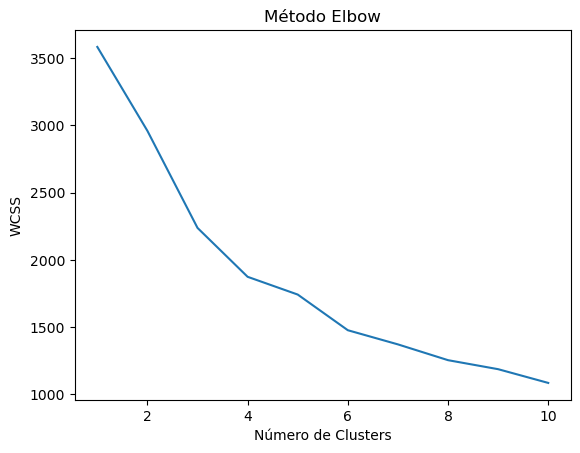

In [11]:

# Determinar o número ideal de clusters usando o método Elbow
# Vamos testar até 10 clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(ConcelhoStats.iloc[:,1:len(ColunasConcelhoInteresse)])
    wcss.append(kmeans.inertia_)

# Plotar o gráfico de Elbow
plt.plot(range(1, 11), wcss)
plt.title('Método Elbow')
plt.xlabel('Número de Clusters')
plt.ylabel('WCSS')  # Within cluster sum of squares
plt.show()

C:\Users\diogo\anaconda3\Lib\site-packages\omniplot\plot.py:106: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Y = sch.linkage(D, method=tree_method)


333 333
333 333
333 333


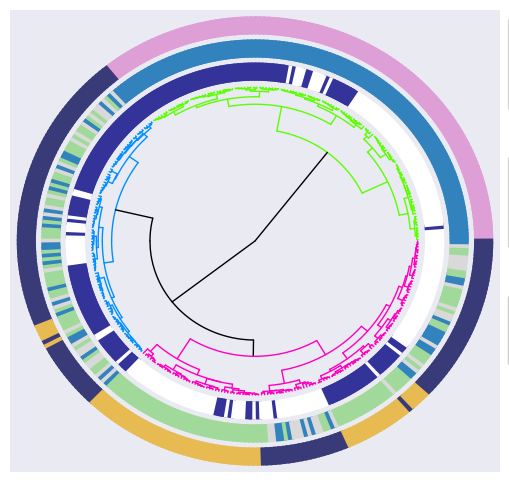

In [12]:
import seaborn as sns
from omniplot import plot as op
import matplotlib.pyplot as plt
df=sns.load_dataset("penguins")
df=df.dropna(axis=0)
res=op.radialtree(df, category=["species","island","sex"])
plt.show()

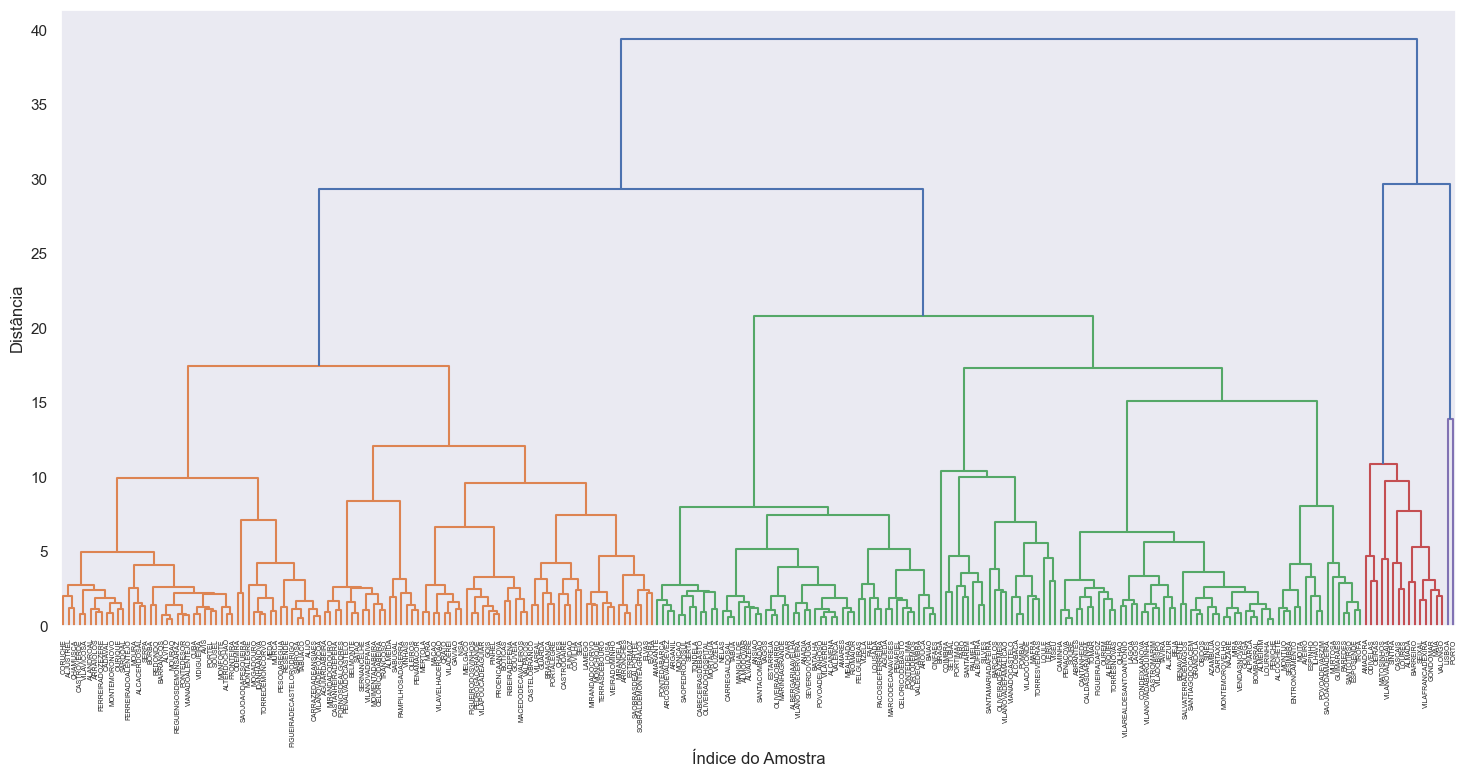

In [13]:
# Executar o algoritmo de clustering hierárquico nos teus próprios dados
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='ward')
model.fit(ConcelhoStats.iloc[:,1:len(ColunasConcelhoInteresse)])

# Função para plotar o dendrograma
def plot_dendrogram(model, **kwargs):
    # Calcula o layout do dendrograma
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # folha
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_, counts]).astype(float)

    # Plota o dendrograma
    dendrogram(linkage_matrix, **kwargs)

# Obtém os nomes dos concelhos
concelhos = ConcelhoStats['concelho'].tolist()

# Plotando o dendrograma
plt.figure(figsize=(18, 8))
plot_dendrogram(model, labels=concelhos)
plt.xlabel('Índice do Amostra')
plt.ylabel('Distância')
plt.grid(False)
plt.savefig("DendogramaConcelhosCluster.png", format='png', bbox_inches='tight')
plt.show()

In [14]:
# Inicialize o modelo Agglomerative Clustering com o número desejado de clusters
n_clusters = 4  # Defina o número de clusters desejado
agg_clustering = AgglomerativeClustering(n_clusters=n_clusters)

# Ajuste o modelo aos dados
agg_clustering.fit(ConcelhoStats.iloc[:,1:len(ColunasConcelhoInteresse)])

# Obtenha as etiquetas de cluster para cada amostra
cluster_labels = agg_clustering.labels_

# Apagar a coluna caso exista (corrir erro de colunas múltiplas)
if 'Cluster_Agglomerative' in QuebrasFinal.columns:
    ConcelhoStats.drop(columns=['Cluster_Agglomerative'], inplace=True)

# Adicione as etiquetas de cluster ao DataFrame QuebrasFinal
ConcelhoStats['Cluster_Agglomerative'] = cluster_labels

Silhouette média para o modelo Agglomerative Clustering: 0.19237679265680302


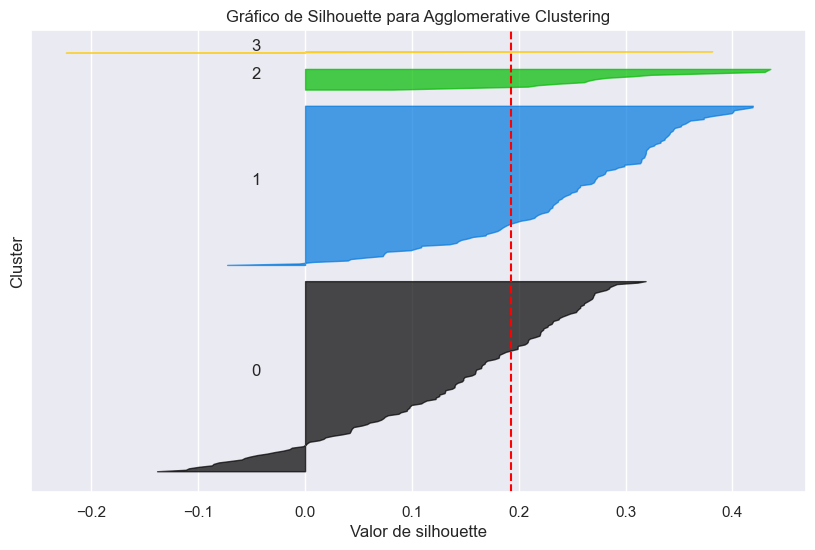

In [15]:
# Calcule a silhouette média para o modelo
silhouette_avg = silhouette_score(ConcelhoStats.iloc[:,1:len(ColunasConcelhoInteresse)], cluster_labels)
print("Silhouette média para o modelo Agglomerative Clustering:", silhouette_avg)

# Calcule a silhouette para cada amostra
sample_silhouette_values = silhouette_samples(ConcelhoStats.iloc[:,1:len(ColunasConcelhoInteresse)], cluster_labels)

# Crie um gráfico de barras para mostrar a silhouette para cada amostra
plt.figure(figsize=(10, 6))
y_lower = 10
for i in range(n_clusters):
    # Agregue a silhouette para amostras pertencentes ao cluster i
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / n_clusters)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Etiqueta do cluster no meio
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Calcule o próximo y_lower para o próximo gráfico
    y_lower = y_upper + 10  

plt.title("Gráfico de Silhouette para Agglomerative Clustering")
plt.xlabel("Valor de silhouette")
plt.ylabel("Cluster")
plt.axvline(x=silhouette_avg, color="red", linestyle="--")  # Linha para indicar a silhouette média
plt.yticks([])  # Limpe os yticks
plt.savefig("SilhouetteConcelhosCluster.svg", format='svg', bbox_inches='tight')
plt.show()


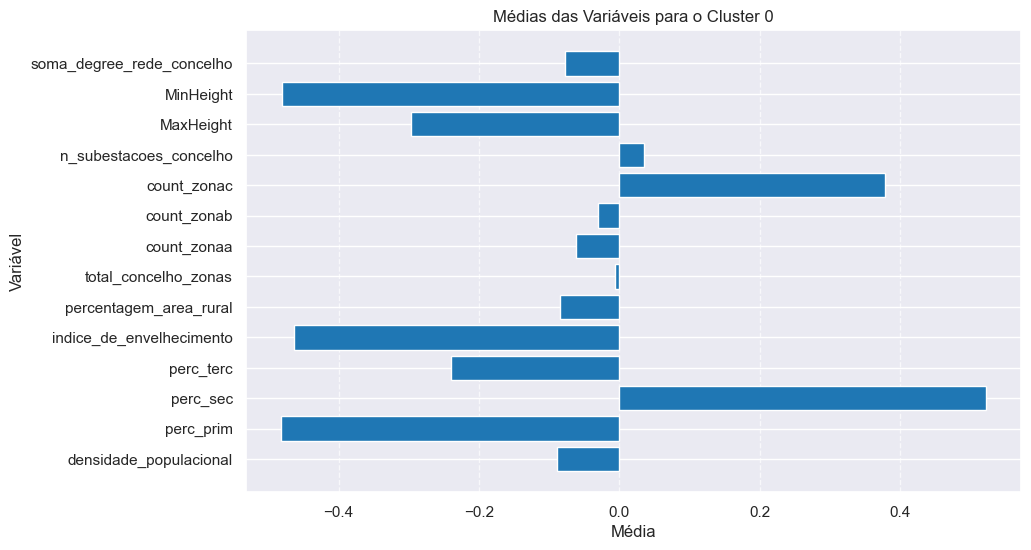

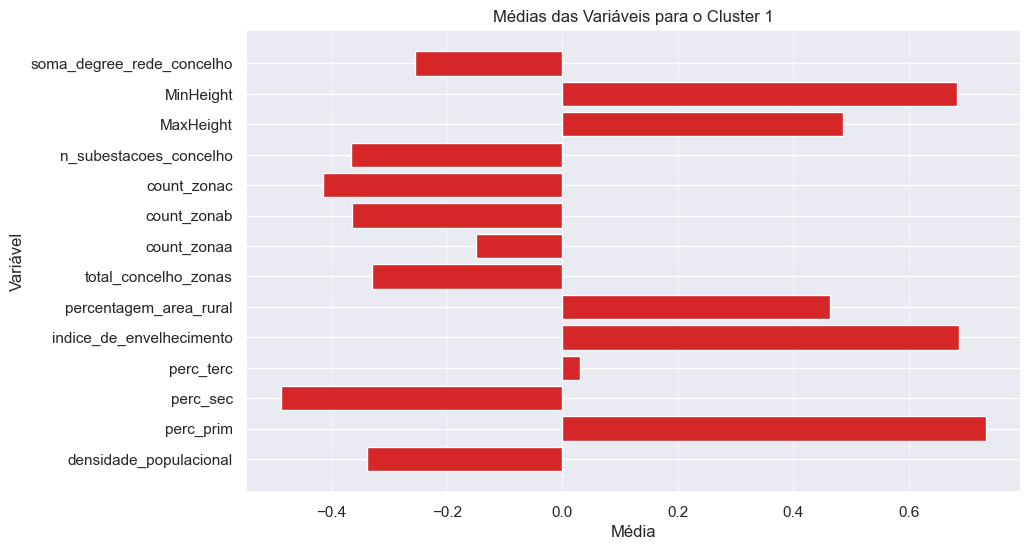

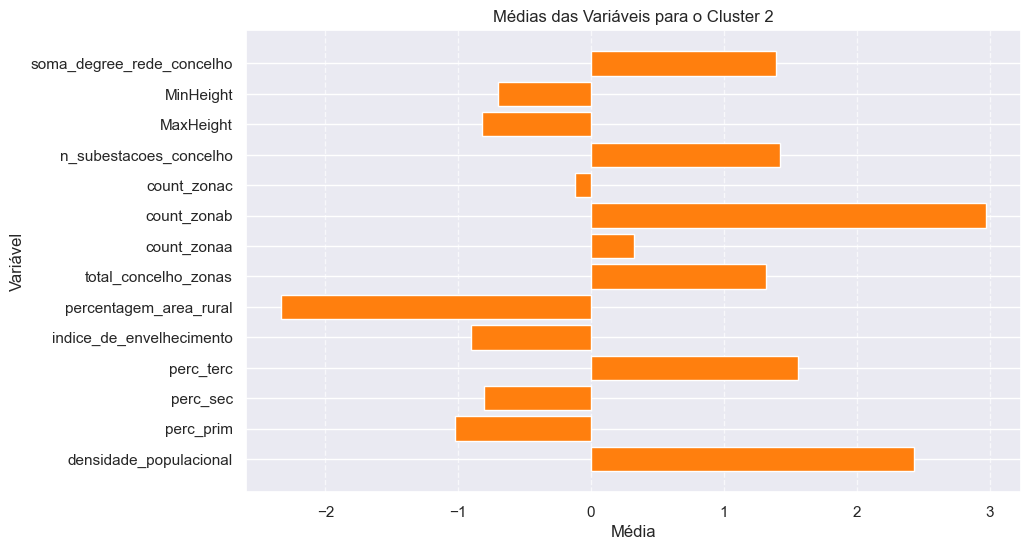

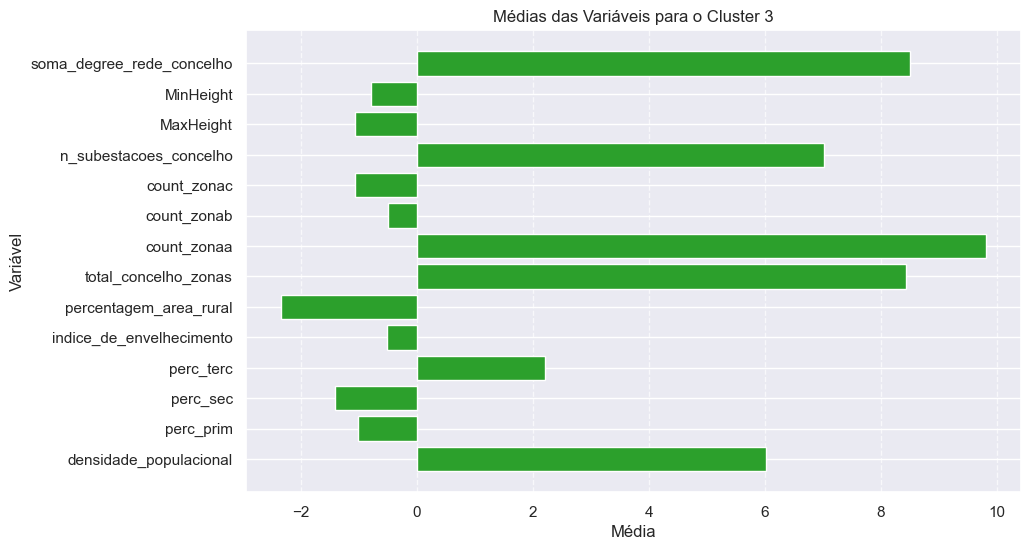

In [16]:
# Agrupar os dados por cluster e calcular as médias
cluster_means = ConcelhoStats.iloc[:,1:22].groupby('Cluster_Agglomerative').mean()

# Definir cores para os clusters
colors =  ['#1f77b4', '#d62728', '#ff7f0e', '#2ca02c']

# Plotar os gráficos de barras para cada cluster
for i, cluster in enumerate(cluster_means.index):
    cluster_data = cluster_means.loc[cluster]
    plt.figure(figsize=(10, 6))
    plt.barh(cluster_data.index, cluster_data.values, color=colors[i])
    plt.title(f'Médias das Variáveis para o Cluster {cluster}')
    plt.xlabel('Média')
    plt.ylabel('Variável')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.savefig(f"ClusterConcelho{i}.svg", format='svg', bbox_inches='tight')
    plt.show()

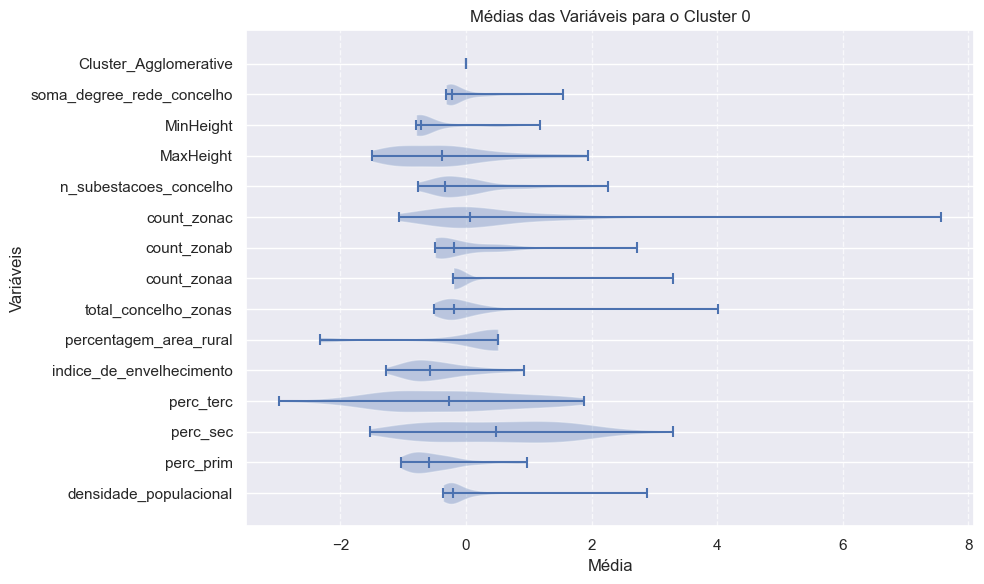

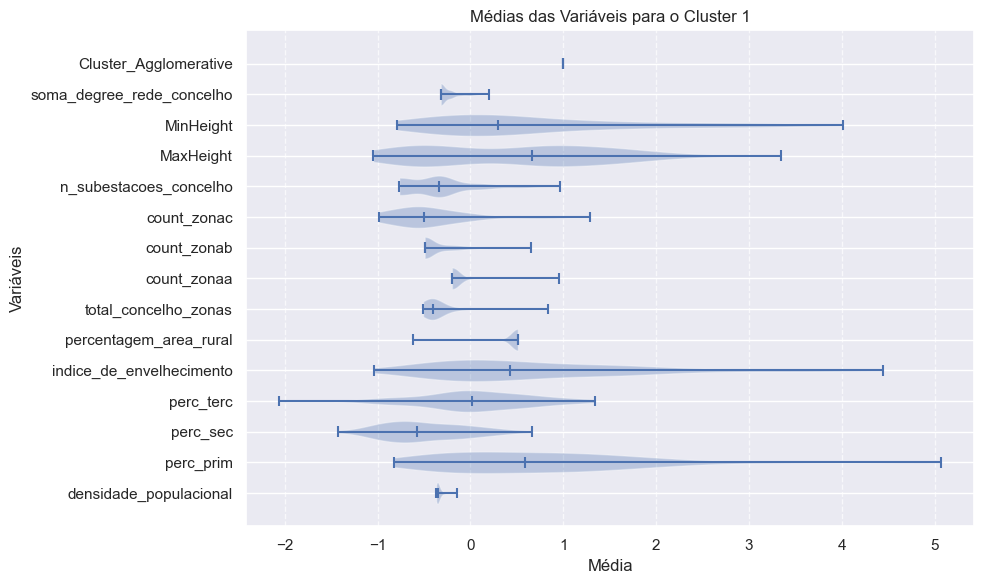

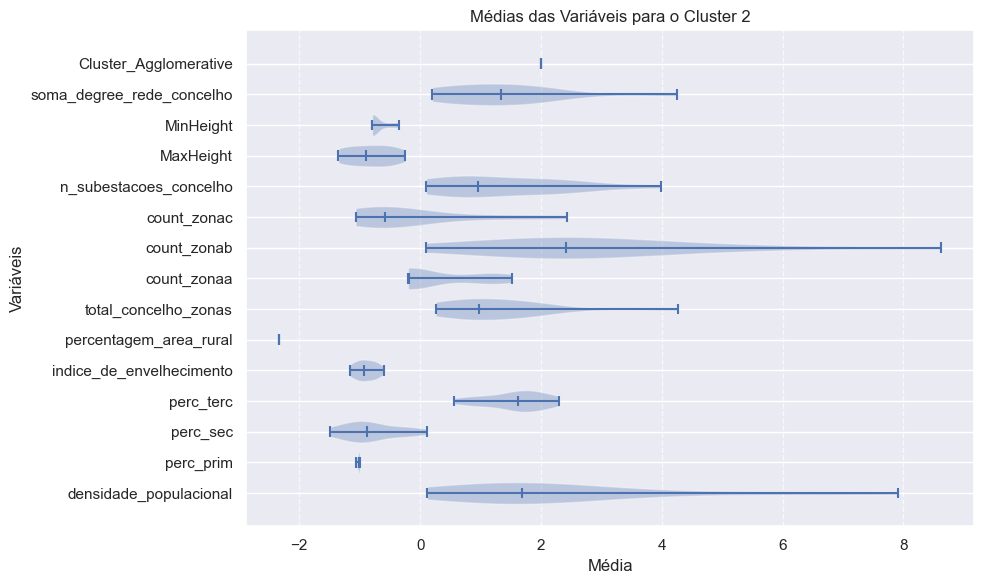

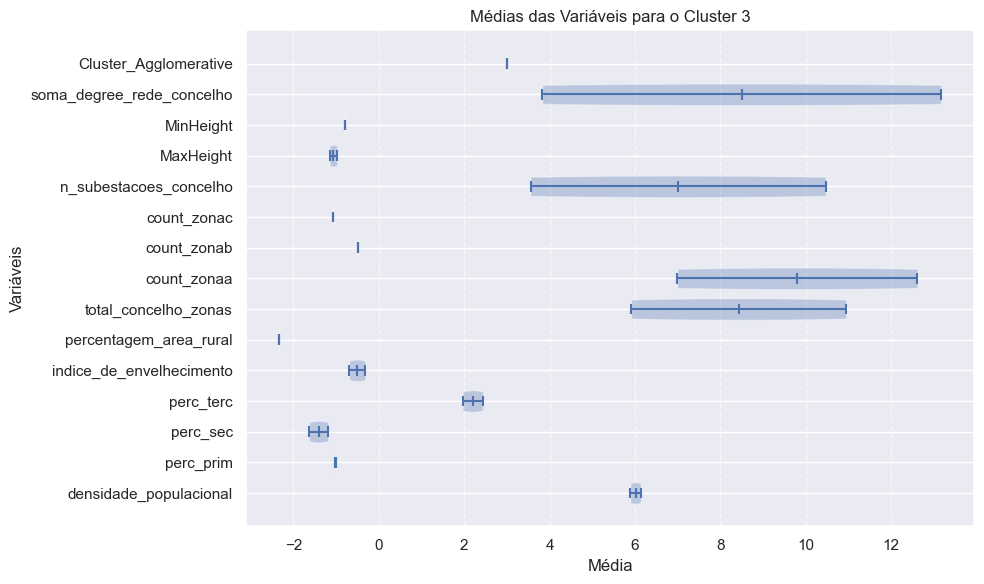

In [17]:
# Definir cores para os clusters
colors = ['blue', 'orange', 'red', 'green']

# Agrupar os dados por cluster
cluster_means = ConcelhoStats.iloc[:, 1:].groupby('Cluster_Agglomerative').mean()

# Plotar os gráficos de violino para cada cluster com cores definidas
for i, cluster in enumerate(cluster_means.index):
    cluster_data = ConcelhoStats[ConcelhoStats['Cluster_Agglomerative'] == cluster].iloc[:, 1:]  # Seleciona todas as variáveis exceto Cluster_Agglomerative
    plt.figure(figsize=(10, 6))
    parts = plt.violinplot(dataset=cluster_data.values, widths=0.7, showmeans=False, showmedians=True, vert=False)
    plt.title(f'Médias das Variáveis para o Cluster {cluster}')
    plt.xlabel('Média')
    plt.ylabel('Variáveis')
    plt.yticks(np.arange(1, len(cluster_data.columns) + 1), cluster_data.columns)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [18]:
ConcelhoClusters = ConcelhoStats[["concelho", "Cluster_Agglomerative"]]
ConcelhoClusters

,concelho,Cluster_Agglomerative
0,ABRANTES,0
1,AGUEDA,0
2,AGUIARDABEIRA,1
3,ALANDROAL,1
4,ALBERGARIAAVELHA,0
...,...,...
251,VILAVICOSA,1
252,VINHAIS,1
253,VISEU,0
254,VIZELA,0


In [19]:
file_path = shape_folder / "concelhos.shp"
Concelho = gpd.read_file(file_path)
Concelho.rename(columns={'NAME_1': 'Distrito'}, inplace=True)
Concelho.rename(columns={'NAME_2': 'concelho'}, inplace=True)
Concelho["concelho"] = Concelho["concelho"].str.upper()

def remover_pontuacao(text):
    text = text.replace('Ç', 'C').replace('Ã', 'A').replace('É', 'E').replace('Â', 'A').replace('Ô', 'O').replace('Á', 'A').replace('Ú', 'U').replace('Ê', 'E').replace('Ó', 'O').replace('Í', 'I')
    return text

Concelho["concelho"] = Concelho["concelho"].apply(remover_pontuacao)
Concelho["concelho"] = Concelho["concelho"].str.replace('-', ' ')
Concelho["concelho"] = Concelho["concelho"].str.replace(' ', '')

Concelho = Concelho[~Concelho['Distrito'].isin(['Azores', 'Madeira'])].reset_index(drop = True)
Concelho

,ID_0,ISO,NAME_0,ID_1,Distrito,ID_2,concelho,HASC_2,CCN_2,CCA_2,TYPE_2,ENGTYPE_2,NL_NAME_2,VARNAME_2,geometry
0,182,PRT,Portugal,1,Évora,1,EVORA,PT.EV.EV,0,0705,Concelho,Municipality,None,None,"POLYGON ((-7.79291 38.76507, -7.79287 38.76506..."
1,182,PRT,Portugal,1,Évora,2,ALANDROAL,PT.EV.AL,0,0701,Concelho,Municipality,None,None,"POLYGON ((-7.25937 38.77351, -7.25921 38.77343..."
2,182,PRT,Portugal,1,Évora,3,ARRAIOLOS,PT.EV.AR,0,0702,Concelho,Municipality,None,None,"POLYGON ((-7.88611 38.92495, -7.88580 38.92472..."
3,182,PRT,Portugal,1,Évora,4,BORBA,PT.EV.BO,0,0703,Concelho,Municipality,None,None,"POLYGON ((-7.46362 38.92344, -7.46344 38.92329..."
4,182,PRT,Portugal,1,Évora,5,ESTREMOZ,PT.EV.ES,0,0704,Concelho,Municipality,None,None,"POLYGON ((-7.52770 39.00080, -7.52765 39.00066..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,182,PRT,Portugal,20,Viseu,302,TAROUCA,PT.VI.TR,0,1820,Concelho,Municipality,None,None,"POLYGON ((-7.72591 41.08079, -7.72442 41.08028..."
274,182,PRT,Portugal,20,Viseu,303,TONDELA,PT.VI.TO,0,1821,Concelho,Municipality,None,None,"POLYGON ((-8.12772 40.64028, -8.12751 40.64027..."
275,182,PRT,Portugal,20,Viseu,304,VILANOVADEPAIVA,PT.VI.VP,0,1822,Concelho,Municipality,None,None,"POLYGON ((-7.77933 40.93439, -7.77835 40.93436..."
276,182,PRT,Portugal,20,Viseu,305,VISEU,PT.VI.VS,0,1823,Concelho,Municipality,None,None,"POLYGON ((-7.80686 40.83789, -7.80653 40.83787..."


In [20]:
Freguesias_com_clusters2 = pd.merge(Concelho, ConcelhoClusters, on='concelho', how='left')
Freguesias_com_clusters2

,ID_0,ISO,NAME_0,ID_1,Distrito,ID_2,concelho,HASC_2,CCN_2,CCA_2,TYPE_2,ENGTYPE_2,NL_NAME_2,VARNAME_2,geometry,Cluster_Agglomerative
0,182,PRT,Portugal,1,Évora,1,EVORA,PT.EV.EV,0,0705,Concelho,Municipality,None,None,"POLYGON ((-7.79291 38.76507, -7.79287 38.76506...",1.0
1,182,PRT,Portugal,1,Évora,2,ALANDROAL,PT.EV.AL,0,0701,Concelho,Municipality,None,None,"POLYGON ((-7.25937 38.77351, -7.25921 38.77343...",1.0
2,182,PRT,Portugal,1,Évora,3,ARRAIOLOS,PT.EV.AR,0,0702,Concelho,Municipality,None,None,"POLYGON ((-7.88611 38.92495, -7.88580 38.92472...",1.0
3,182,PRT,Portugal,1,Évora,4,BORBA,PT.EV.BO,0,0703,Concelho,Municipality,None,None,"POLYGON ((-7.46362 38.92344, -7.46344 38.92329...",1.0
4,182,PRT,Portugal,1,Évora,5,ESTREMOZ,PT.EV.ES,0,0704,Concelho,Municipality,None,None,"POLYGON ((-7.52770 39.00080, -7.52765 39.00066...",1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273,182,PRT,Portugal,20,Viseu,302,TAROUCA,PT.VI.TR,0,1820,Concelho,Municipality,None,None,"POLYGON ((-7.72591 41.08079, -7.72442 41.08028...",NaN
274,182,PRT,Portugal,20,Viseu,303,TONDELA,PT.VI.TO,0,1821,Concelho,Municipality,None,None,"POLYGON ((-8.12772 40.64028, -8.12751 40.64027...",0.0
275,182,PRT,Portugal,20,Viseu,304,VILANOVADEPAIVA,PT.VI.VP,0,1822,Concelho,Municipality,None,None,"POLYGON ((-7.77933 40.93439, -7.77835 40.93436...",1.0
276,182,PRT,Portugal,20,Viseu,305,VISEU,PT.VI.VS,0,1823,Concelho,Municipality,None,None,"POLYGON ((-7.80686 40.83789, -7.80653 40.83787...",0.0


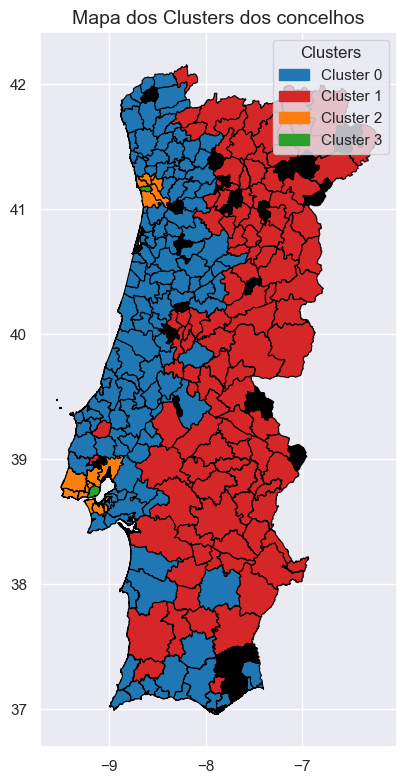

In [21]:
# Certifique-se de que o DataFrame é um GeoDataFrame
if not isinstance(Freguesias_com_clusters2, gpd.GeoDataFrame):
    Freguesias_com_clusters2 = gpd.GeoDataFrame(Freguesias_com_clusters2, geometry='geometry')

# Definir cores fixas para cada cluster
colors = ['#1f77b4', '#d62728', '#ff7f0e', '#2ca02c']
cmap = ListedColormap(colors)
norm = BoundaryNorm([0, 1, 2, 3], cmap.N)

# Configurar a figura e os eixos para o mapa
fig, ax = plt.subplots(1, 1, figsize=(20, 8))

missing_color = 'black'

# Plotar o mapa das freguesias, colorindo pelos clusters
Freguesias_com_clusters2.plot(column='Cluster_Agglomerative', cmap=cmap, linewidth=0.8, edgecolor='black', ax=ax, legend=False, missing_kwds={'color': missing_color})

# Adicionar título ao mapa
ax.set_title('Mapa dos Clusters dos concelhos', fontsize=14)

# Adicionar legenda manualmente
handles = [
    mpatches.Patch(color=colors[0], label='Cluster 0'),
    mpatches.Patch(color=colors[1], label='Cluster 1'),
    mpatches.Patch(color=colors[2], label='Cluster 2'),
    mpatches.Patch(color=colors[3], label='Cluster 3'),
]
ax.legend(handles=handles, title='Clusters')

# Ajustar layout
plt.tight_layout()

plt.savefig("ClusterConcelhoMapa.png", format='png', bbox_inches='tight')

# Exibir o mapa
plt.show()


In [22]:
QuebrasFinal.columns

Index(['codigo_do_relatorio', 'concelho', 'data_do_incidente',
       'nivel_de_tensao', 'causa_do_incidente', 'duracao_incidente_min_',
       'n_º_clientes_afetados', 'tiepi_mt_min_', 'saifi_mt_#_',
       'saidi_mt_min_', 'end_mwh_', 'saifi_bt_#_', 'saidi_bt_min_', 'decisao',
       'distrito', 'densidade_populacional', 'populacao_residente',
       'setor_primario', 'setor_secundario', 'setor_terciario',
       'indice_de_envelhecimento', 'rural', 'count_zonaa', 'count_zonab',
       'count_zonac', 'total_concelho_zonas', 'percentagem_zonaa',
       'percentagem_zonab', 'percentagem_zonac', 'soma_degree_rede_concelho',
       'n_subestacoes_concelho', 'classe_da_causa_4', 'classe_da_causa_6',
       'perc_prim', 'perc_sec', 'perc_terc', 'sen_ano', 'cos_ano', 'sen_mes',
       'cos_mes', 't_med', 't_max', 't_min', 'dd_med', 'dd_ffx', 'ff_med',
       'ff_max', 'pr_qtd', 'MaxHeight', 'MinHeight', 'percentagem_area_rural'],
      dtype='object')

In [23]:
cols_to_drop = ['densidade_populacional', 'populacao_residente', 'setor_primario', 'setor_secundario', 'setor_terciario',
       'indice_de_envelhecimento', 'rural', 'count_zonaa', 'count_zonab',
       'count_zonac', 'total_concelho_zonas', 'percentagem_zonaa',
       'percentagem_zonab', 'percentagem_zonac', 'soma_degree_rede_concelho',
       'n_subestacoes_concelho','perc_prim', 'perc_sec', 'perc_terc', 'MaxHeight', 'MinHeight', 'percentagem_area_rural']
QuebrasFinalINC = QuebrasFinal.drop(cols_to_drop, axis=1)
QuebrasFinalINC

,codigo_do_relatorio,concelho,data_do_incidente,nivel_de_tensao,causa_do_incidente,duracao_incidente_min_,n_º_clientes_afetados,tiepi_mt_min_,saifi_mt_#_,saidi_mt_min_,...,sen_mes,cos_mes,t_med,t_max,t_min,dd_med,dd_ffx,ff_med,ff_max,pr_qtd
0,EDPD_2018_JAN_T_1,ALMADA,2018-01-02,MT,Escavações,55,828,0.002935,0.000044,0.002456,...,0.394356,0.918958,10.70,17.40,2.600,278.25,289.50,2.0,7.800,0.000000
1,EDPD_2018_JAN_T_2,SERTA,2018-01-02,MT,Abate De Árvores,163,549,0.002933,0.000177,0.016501,...,0.394356,0.918958,10.60,13.80,6.200,249.00,270.00,2.8,8.100,0.000000
2,EDPD_2018_JAN_T_3,FELGUEIRAS,2018-01-04,MT,Deslizamento De Terras,596,3459,0.019228,0.000266,0.035905,...,0.724793,0.688967,14.00,14.80,12.900,197.00,180.00,3.9,14.400,4.000000
3,EDPD_2018_JAN_T_4,TORRESVEDRAS,2018-01-05,BT,Veículos,178,102,0.000000,0.000000,0.000000,...,0.848644,0.528964,12.40,15.10,9.100,288.00,225.00,3.6,13.900,13.200000
4,EDPD_2018_JAN_T_5,NISA,2018-01-09,MT,Aves,119,1731,0.004422,0.000155,0.010038,...,0.968077,-0.250653,4.90,7.80,2.200,137.00,118.00,4.1,15.400,15.900000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,EDPD_2020_DEZ_T_21,POMBAL,2020-12-24,MT,Abate De Árvores,139,2517,0.005941,0.000461,0.017245,...,-0.988468,0.151428,7.90,12.20,2.100,7.00,351.00,1.7,7.600,0.000000
2918,EDPD_2020_DEZ_T_22,VILANOVADEGAIA,2020-12-30,MT,Aves,81,3641,0.011914,0.000290,0.011131,...,-0.201299,0.979530,4.45,9.05,0.275,239.00,186.25,1.5,4.825,0.787500
2919,EDPD_2020_DEZ_T_23,ALBUFEIRA,2020-12-28,MT,Escavações,81,3175,0.005974,0.000086,0.005940,...,-0.571268,0.820763,13.20,15.30,7.700,285.00,293.00,5.8,14.100,0.100000
2920,EDPD_2020_DEZ_T_24,CASTROMARIM,2020-12-28,MT,Veículos,239,591,0.006928,0.000054,0.011528,...,-0.571268,0.820763,13.20,15.30,7.700,285.00,293.00,5.8,14.100,0.100000


In [24]:
ConcelhoClusters

,concelho,Cluster_Agglomerative
0,ABRANTES,0
1,AGUEDA,0
2,AGUIARDABEIRA,1
3,ALANDROAL,1
4,ALBERGARIAAVELHA,0
...,...,...
251,VILAVICOSA,1
252,VINHAIS,1
253,VISEU,0
254,VIZELA,0


In [25]:
Completo = pd.merge(QuebrasFinalINC, ConcelhoClusters, on=['concelho'])
TiposClusters = {0: 'Litoral e ZonasIndustrias',  1: 'Interior', 2: 'Arredores das Grandes cidades', 3:"Grandes Cidades"}
Completo["Cluster_Agglomerative"].replace(TiposClusters, inplace=True)
Completo

,codigo_do_relatorio,concelho,data_do_incidente,nivel_de_tensao,causa_do_incidente,duracao_incidente_min_,n_º_clientes_afetados,tiepi_mt_min_,saifi_mt_#_,saidi_mt_min_,...,cos_mes,t_med,t_max,t_min,dd_med,dd_ffx,ff_med,ff_max,pr_qtd,Cluster_Agglomerative
0,EDPD_2018_JAN_T_1,ALMADA,2018-01-02,MT,Escavações,55,828,0.002935,0.000044,0.002456,...,0.918958,10.7,17.4,2.6,278.25,289.5,2.0,7.8,0.0,Arredores das Grandes cidades
1,EDPD_2018_JUN_T_20,ALMADA,2018-06-15,MT,Escavações,262,2657,0.006267,0.000044,0.008009,...,-1.000000,20.4,27.1,15.5,345.00,351.0,4.3,14.3,0.0,Arredores das Grandes cidades
2,EDPD_2018_AGO_T_44,ALMADA,2018-08-30,MT,Escavações,97,3657,0.005956,0.000055,0.003870,...,0.979530,23.4,34.3,15.8,340.00,2.0,2.2,9.0,0.0,Arredores das Grandes cidades
3,EDPD_2018_SET_T_50,ALMADA,2018-09-10,MT,Escavações,63,3009,0.006319,0.000077,0.004607,...,-0.500000,25.1,35.3,16.4,5.00,331.0,2.6,9.1,0.0,Arredores das Grandes cidades
4,EDPD_2021_JAN_T_9,ALMADA,2021-01-08,MT,Inundações Imprevisíveis,583,1962,0.009740,0.000030,0.008560,...,-0.050649,6.0,10.3,3.8,9.00,1.0,3.8,12.4,0.0,Arredores das Grandes cidades
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,EDPD_2020_MAI_T_33,MIRANDADODOURO,2020-05-21,MT,Intervenções À Superficie,153,827,0.012402,0.000140,0.017559,...,-0.440394,21.7,29.1,12.6,216.00,163.0,2.0,10.9,0.0,Interior
2918,EDPD_2020_JUL_T_9,FIGUEIRADECASTELORODRIGO,2020-07-11,MT,Descarga Atmosférica Directa,323,65,0.008296,0.000118,0.024722,...,-0.612106,21.7,32.1,14.9,41.00,272.0,3.6,20.1,4.4,Interior
2919,EDPD_2020_AGO_T_26,FIGUEIRADECASTELORODRIGO,2020-08-27,MT,Aves,21,3,0.000032,0.000011,0.000222,...,0.688967,21.0,27.8,15.3,307.00,295.0,5.7,13.8,0.0,Interior
2920,EDPD_2020_AGO_T_14,SERNANCELHE,2020-08-06,MT,Risco Iminente Pessoas Ou Bens,287,525,0.004722,0.000086,0.016253,...,0.347305,27.3,35.5,20.0,309.00,281.0,3.4,9.4,0.0,Interior


In [26]:
dummies = pd.get_dummies(Completo['Cluster_Agglomerative'], prefix='Cluster')
dummies = dummies.astype(int)
dummies

,Cluster_Arredores das Grandes cidades,Cluster_Grandes Cidades,Cluster_Interior,Cluster_Litoral e ZonasIndustrias
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
2917,0,0,1,0
2918,0,0,1,0
2919,0,0,1,0
2920,0,0,1,0


In [27]:
Completo = pd.concat([Completo, dummies], axis=1)
Completo.drop("Cluster_Agglomerative", axis=1, inplace=True)
Completo

,codigo_do_relatorio,concelho,data_do_incidente,nivel_de_tensao,causa_do_incidente,duracao_incidente_min_,n_º_clientes_afetados,tiepi_mt_min_,saifi_mt_#_,saidi_mt_min_,...,t_min,dd_med,dd_ffx,ff_med,ff_max,pr_qtd,Cluster_Arredores das Grandes cidades,Cluster_Grandes Cidades,Cluster_Interior,Cluster_Litoral e ZonasIndustrias
0,EDPD_2018_JAN_T_1,ALMADA,2018-01-02,MT,Escavações,55,828,0.002935,0.000044,0.002456,...,2.6,278.25,289.5,2.0,7.8,0.0,1,0,0,0
1,EDPD_2018_JUN_T_20,ALMADA,2018-06-15,MT,Escavações,262,2657,0.006267,0.000044,0.008009,...,15.5,345.00,351.0,4.3,14.3,0.0,1,0,0,0
2,EDPD_2018_AGO_T_44,ALMADA,2018-08-30,MT,Escavações,97,3657,0.005956,0.000055,0.003870,...,15.8,340.00,2.0,2.2,9.0,0.0,1,0,0,0
3,EDPD_2018_SET_T_50,ALMADA,2018-09-10,MT,Escavações,63,3009,0.006319,0.000077,0.004607,...,16.4,5.00,331.0,2.6,9.1,0.0,1,0,0,0
4,EDPD_2021_JAN_T_9,ALMADA,2021-01-08,MT,Inundações Imprevisíveis,583,1962,0.009740,0.000030,0.008560,...,3.8,9.00,1.0,3.8,12.4,0.0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,EDPD_2020_MAI_T_33,MIRANDADODOURO,2020-05-21,MT,Intervenções À Superficie,153,827,0.012402,0.000140,0.017559,...,12.6,216.00,163.0,2.0,10.9,0.0,0,0,1,0
2918,EDPD_2020_JUL_T_9,FIGUEIRADECASTELORODRIGO,2020-07-11,MT,Descarga Atmosférica Directa,323,65,0.008296,0.000118,0.024722,...,14.9,41.00,272.0,3.6,20.1,4.4,0,0,1,0
2919,EDPD_2020_AGO_T_26,FIGUEIRADECASTELORODRIGO,2020-08-27,MT,Aves,21,3,0.000032,0.000011,0.000222,...,15.3,307.00,295.0,5.7,13.8,0.0,0,0,1,0
2920,EDPD_2020_AGO_T_14,SERNANCELHE,2020-08-06,MT,Risco Iminente Pessoas Ou Bens,287,525,0.004722,0.000086,0.016253,...,20.0,309.00,281.0,3.4,9.4,0.0,0,0,1,0


In [28]:
Completo.to_feather("EventosFinalComClusterConcelhos.feather")